# Decision Tree model for acoustic features related to emotional speech

##### Haotian Cui, 20-2-2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('all_1440_eGeMAPSv01b.csv')

In [3]:
feature_list = list(df.iloc[:, 7:])
X = df.iloc[:, 7:].to_numpy()
ylabel = df['Emotion'].map(lambda x: x-1).to_numpy()

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, ylabel, test_size=0.2, random_state=1)

## Tree planter ⬇️

Function for hyperparameter tuning and analysis.

In [5]:
def tree_planter(Xtrain, ytrain, Xtest, ytest,
                 criterion='gini', 
                 random_state=123, 
                 max_depth_MIN=2,
                 max_depth_MAX=30,
                 print_best_score=True,
                 score_depth_plot=False,
                 return_score=False):
    
    # loop through custom max depths until the best accuracy score is reached
    score = []
    for i in range(max_depth_MIN, max_depth_MAX):
        tree_model = DecisionTreeClassifier(criterion=criterion, 
                                            random_state=random_state, 
                                            max_depth=i)       
        tree_model.fit(Xtrain, ytrain)
        score.append(round(tree_model.score(Xtest, ytest), 4))

    # get the best accuracy score and the corresponding max_depth
    (max_score, max_score_depth) = (max(score), score.index(max(score)) + max_depth_MIN)
    
    # print best score
    if print_best_score==True:
        print("------- Max_depth of the best accuracy score (validation set) -------")
        print("score: ", max_score)
        print("depth: ", max_score_depth)
    elif print_best_score==False:
        pass
    else:
        print("Error: Wrong print_best_score value!")
    
    # score depth plot
    if score_depth_plot==True:
        fig, ax = plt.subplots(figsize=(8, 6))
        plt.plot(score, color='yellowgreen', marker="o")
        plt.xticks(ticks=[i for i in range(0, len(range(max_depth_MIN, max_depth_MAX)))],
                   labels=[str(i) for i in range(max_depth_MIN, max_depth_MAX)])
        plt.xlabel("Max depth", horizontalalignment='center')
        plt.ylabel("Accuracy Score")
        for x, y in zip([i for i in range(0, len(range(max_depth_MIN, max_depth_MAX)))], score):
            plt.text(x, y, y, fontsize=10, rotation=30, horizontalalignment='left')
        plt.show()
    elif score_depth_plot==False:
        pass
    else:
        print("Error: Wrong score_depth_plot value!")
    
    # return the model with best max_depth parameter
    tree_model = DecisionTreeClassifier(criterion=criterion, 
                                        random_state=random_state, 
                                        max_depth=max_score_depth).fit(Xtrain, ytrain)

    if return_score==True:
        return max_score

    else:
        return tree_model

In [6]:
len([i for i in range(2, 30)])

28

In [7]:
len([i for i in range(1, len(range(2, 30)))])

27

## Feature importance 

Feed all 88 features into the deision tree to find the best max_depth for performance.

------- Max_depth of the best accuracy score (validation set) -------
score:  0.3958
depth:  14


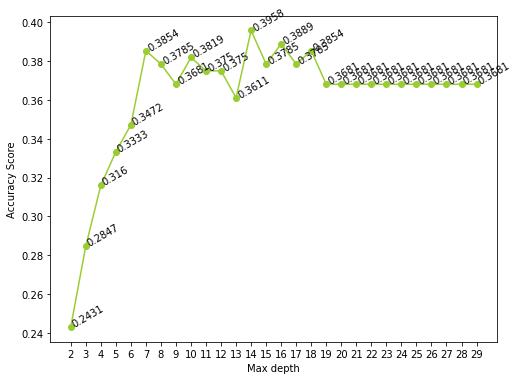

In [8]:
tree_model = tree_planter(Xtrain, ytrain, Xtest, ytest, max_depth_MIN=2, max_depth_MAX=30, score_depth_plot=True)

Get feature importace scores.

In [9]:
importance = tree_model.feature_importances_

importance_sorted = sorted(importance, reverse=True)

# get feature names by score indices
importance_index = importance.argsort()[::-1]
feature_by_importance = [feature_list[i] for i in importance_index]

# build a feature to importance dict for reference and later use
feat_dict = {}
for i, j in zip(feature_by_importance, importance_sorted):
    feat_dict[i] = j

print("importance score: ", importance_sorted[:5]) 
print()
print("corresponding features: ", feature_by_importance[:5])

importance score:  [0.08726523765683657, 0.07230755530151318, 0.03721244147437879, 0.03444662720155593, 0.03051547857406343]

corresponding features:  ['F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'spectralFlux_sma3_amean', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevNorm', 'jitterLocal_sma3nz_amean']


Plot feature importance.

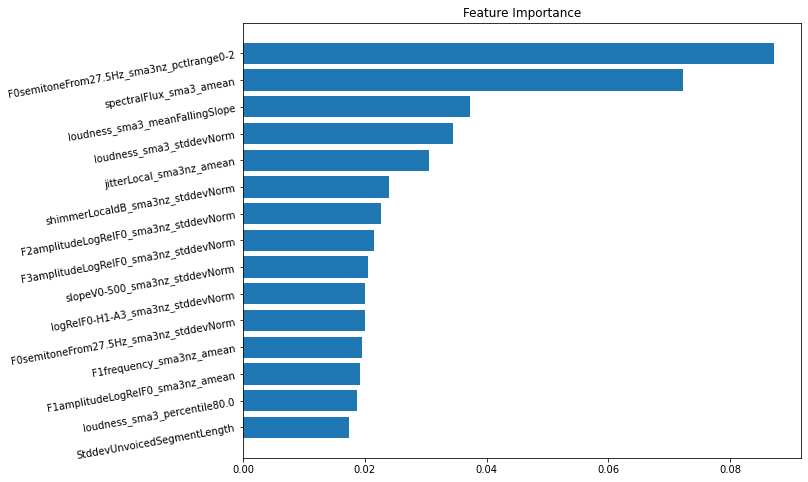

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.barh(np.arange(
                   len(feature_by_importance[:15])
                   ), 
                   importance_sorted[:15][::-1]
                   )
# plt.xticks(feature_by_importance[:12], rotation='vertical')
plt.yticks(np.arange(
                   len(feature_by_importance[:15])
                   ), 
                   feature_by_importance[:15][::-1],
                   rotation=10)
ax.set_title("Feature Importance")
# plt.savefig('./feature_importance.png')
plt.show()

## Results

In [11]:
# loop through features by the order of importance and max_depth from 2 to 60 to find the best performance
tree_model_score = []
for i in range(1, 89):
    important_X = df[feature_by_importance[0:i]]
    
    Xtrain_imp, Xtest_imp, ytrain_imp, ytest_imp = train_test_split(important_X, ylabel, test_size=0.2, random_state=1)
    
    tree_model_score.append(tree_planter(Xtrain_imp, ytrain_imp, Xtest_imp, ytest_imp, 
                                         max_depth_MIN=2, 
                                         max_depth_MAX=60, 
                                         print_best_score=False, 
                                         return_score=True)
                            )

plot accuracy score on the basis of the 88 iterations, each iteration adding one "less" important feature.

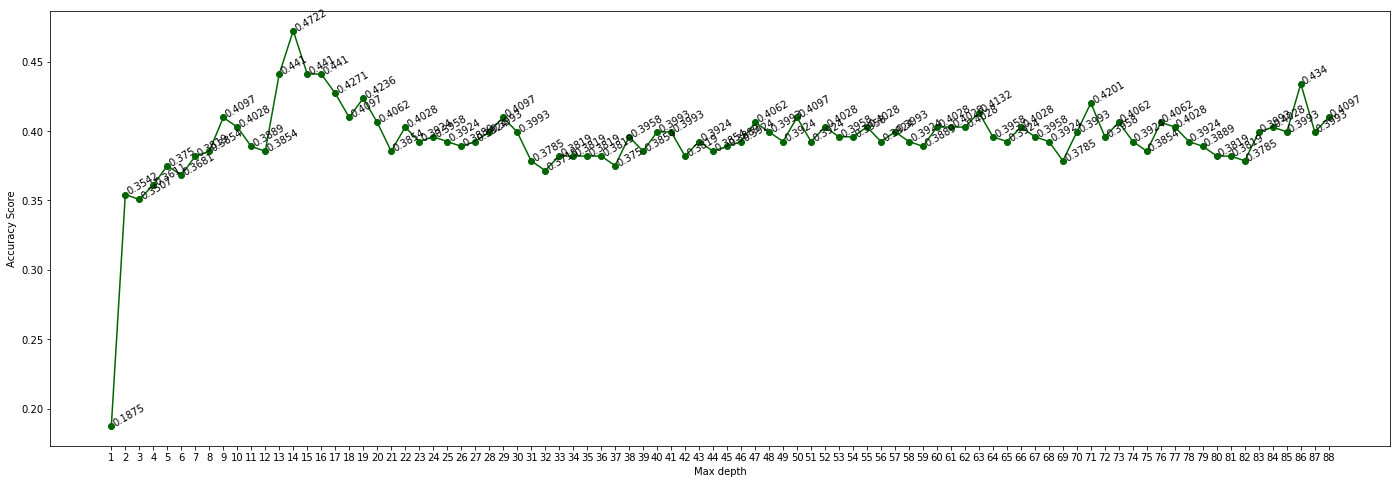

In [12]:
fig, ax = plt.subplots(figsize=(24, 8))
plt.plot(tree_model_score, color='darkgreen', marker="o")
plt.xticks(ticks=[i for i in range(0, len(range(1, 89)))],
                   labels=[str(i) for i in range(1, 89)])
plt.xlabel("Max depth", horizontalalignment='center')
plt.ylabel("Accuracy Score")
for x, y in zip([i for i in range(0, len(range(1, 89)))], tree_model_score):
            plt.text(x, y, y, fontsize=10, rotation=30, horizontalalignment='left')
plt.show()

In [13]:
print("------- Results -------")
print("Best sccuracy score: ", max(tree_model_score))
print("Top ___ features for best performance: ", tree_model_score.index(max(tree_model_score))+1)

------- Results -------
Best sccuracy score:  0.4722
Top ___ features for best performance:  14


### Final model

Now we only take the 14 most importan features as input X.

In [14]:
# split data gain
Xtrain_fin, Xtest_fin, ytrain_fin, ytest_fin = train_test_split(df[feature_by_importance[0:14]], ylabel, test_size=0.2, random_state=1)

In [15]:
# max_depth_MIN=14, max_depth_MAX=15 gives only one input of 14.
final_model = tree_planter(Xtrain_fin, ytrain_fin, Xtest_fin, ytest_fin,
                           criterion='gini', 
                           random_state=123, 
                           max_depth_MIN=10, 
                           max_depth_MAX=30)

------- Max_depth of the best accuracy score (validation set) -------
score:  0.4722
depth:  14


The accuracy score is the best when the first 14 features are included. They are:

In [16]:
print("------ Top 14 most important features ------")
print()
for i in feature_by_importance[:14]:
    print(i, ' -> ', feat_dict[i])

------ Top 14 most important features ------

F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2  ->  0.08726523765683657
spectralFlux_sma3_amean  ->  0.07230755530151318
loudness_sma3_meanFallingSlope  ->  0.03721244147437879
loudness_sma3_stddevNorm  ->  0.03444662720155593
jitterLocal_sma3nz_amean  ->  0.03051547857406343
shimmerLocaldB_sma3nz_stddevNorm  ->  0.02405048215640066
F2amplitudeLogRelF0_sma3nz_stddevNorm  ->  0.022598405450473796
F3amplitudeLogRelF0_sma3nz_stddevNorm  ->  0.021522097347238874
slopeV0-500_sma3nz_stddevNorm  ->  0.020534993855489424
logRelF0-H1-A3_sma3nz_stddevNorm  ->  0.0200338043221464
F0semitoneFrom27.5Hz_sma3nz_stddevNorm  ->  0.020029001118642906
F1frequency_sma3nz_amean  ->  0.01962583997734834
F1amplitudeLogRelF0_sma3nz_amean  ->  0.019158888671411446
loudness_sma3_percentile80.0  ->  0.01869742740149329
